# 2D Potential u(theta, phi)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from renormalization_np import track_rg_flow

def plot_potential_vs_relative_angle(J1, J2, M, n_max=20, n_rg_steps=20, fixed_phi_values=None, b=2, d=2):
    """
    Plot the potential u (exponentiated Hamiltonian) versus a single relative angle
    at the RG sink, with normalized y-axis.
    
    Args:
        J1: First 2-spin coupling constant
        J2: Second 2-spin coupling constant
        M: 4-spin coupling constant
        n_max: Maximum Fourier mode
        n_rg_steps: Number of RG steps to reach the sink
        fixed_phi_values: List of phi values to fix when plotting u vs theta
                          If None, uses [0, π/4, π/2, 3π/4, π]
        b: Length rescaling factor
        d: Dimension
    
    Returns:
        Matplotlib figure
    """
    # Track RG flow to get coefficients at the sink
    flow_history = track_rg_flow(J1, J2, M, b, d, n_max, n_rg_steps)
    
    # Get the final coefficients (at the sink)
    final_coeffs = flow_history[-1]
    
    # Create a range of theta values from 0 to π
    theta_values = np.linspace(0, np.pi, 200)
    
    # If no phi values provided, use these defaults
    if fixed_phi_values is None:
        fixed_phi_values = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Store all u_values to find global maximum for normalization
    all_u_values = []
    
    # Calculate potential for each fixed phi value
    u_values_dict = {}
    for phi in fixed_phi_values:
        # Calculate potential u for each theta with fixed phi
        u_values = np.zeros_like(theta_values, dtype=complex)
        
        # Reconstruct potential from Fourier coefficients
        for n in range(-n_max, n_max + 1):
            for m in range(-n_max, n_max + 1):
                n_idx = n + n_max
                m_idx = m + n_max
                u_values += final_coeffs[n_idx, m_idx] * np.exp(1j * (n*theta_values + m*phi))
        
        # Take absolute value or real part as appropriate
        u_real = np.abs(u_values)  # Using absolute value as potential is real but complex numbers used in computation
        
        # Store for later plotting (after normalization)
        u_values_dict[phi] = u_real
        all_u_values.extend(u_real)
    
    # Find global maximum for normalization
    global_max = max(all_u_values)
    
    # Plot normalized potential for each fixed phi value
    for phi, u_real in u_values_dict.items():
        # Normalize
        u_normalized = u_real / global_max
        
        # Plot the curve for this phi value
        if phi == 0:
            label = 'φ = 0'
        elif phi == np.pi/4:
            label = 'φ = π/4'
        elif phi == np.pi/2:
            label = 'φ = π/2'
        elif phi == 3*np.pi/4:
            label = 'φ = 3π/4'
        elif phi == np.pi:
            label = 'φ = π'
        else:
            label = f'φ = {phi:.2f}'
            
        ax.plot(theta_values, u_normalized, label=label, linewidth=2)
    
    # Add labels and title
    ax.set_xlabel('Relative Angle θ', fontsize=14)
    ax.set_ylabel('Normalized Potential u(θ,φ)', fontsize=14)
    ax.set_title(f'Normalized Potential u vs Relative Angle θ at RG Sink\n(J1={J1}, J2={J2}, M={M})', 
                 fontsize=14)
    
    # Add grid and legend
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=12)
    
    # Set x-axis ticks to show in terms of π
    ax.set_xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
    ax.set_xticklabels(['0', 'π/4', 'π/2', '3π/4', 'π'])
    
    # Set axis limits
    ax.set_xlim(0, np.pi)
    ax.set_ylim(0, 1.05)  # Add a little space at the top
    
    fig.tight_layout()
    
    return fig

100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


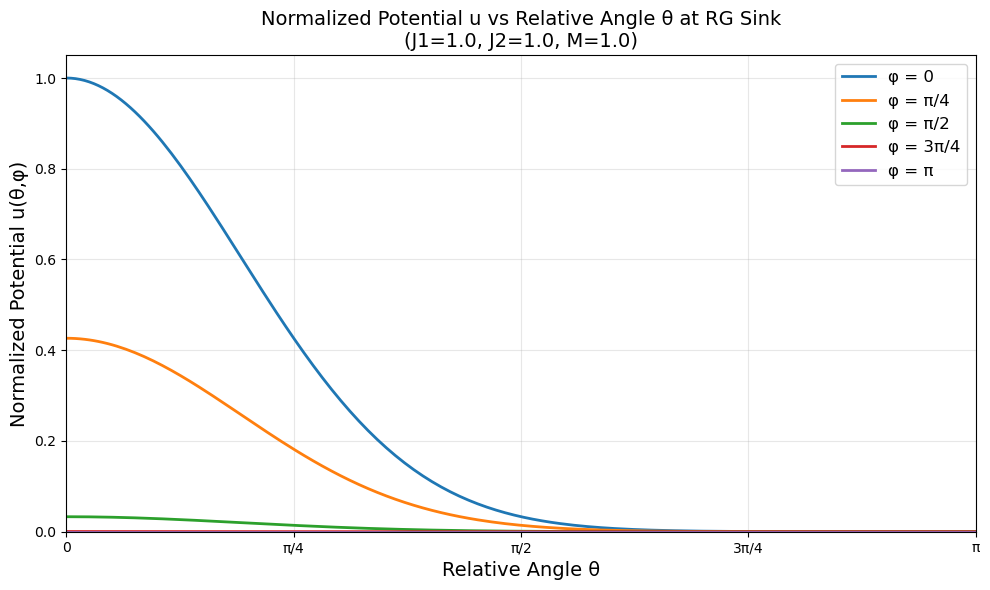

In [18]:
from renormalization_np import track_rg_flow

# Define parameters
J1 = 1.0    # First 2-spin coupling
J2 = 1.0    # Second 2-spin coupling (same as J1 for symmetric case)
M = 1.0     # 4-spin coupling

# Analyze RG flow
#analyze_rg_flow(J1, J2, M, n_max=20, n_rg_steps=10, b=3, d=2)

# Plot potential versus relative angle
fixed_phi_values = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
fig = plot_potential_vs_relative_angle(J1, J2, M, n_max=20, n_rg_steps=15, 
                                      fixed_phi_values=fixed_phi_values, b=3, d=2)

#plt.savefig(f"potential.png", dpi=100, bbox_inches='tight')
plt.show()

# 2D Potential u(theta), Energy

In [69]:
import numpy as np
import matplotlib.pyplot as plt

def plot_2d_potential_energy(lambda_nm, mode='potential', title=None, n_points=500, 
                            angle_range=(0, np.pi), figsize=(10, 6), normalize=True,
                            epsilon=1e-15, J1=None, J2=None, M=None):
    """
    Plot 2D potential or energy for a single angle, especially useful when M=0.
    
    Args:
        lambda_nm: 2D array of Fourier coefficients
        mode: 'potential' to plot |u(θ)| or 'energy' to plot -log(|u(θ)|) (default: 'potential')
        title: Title for the plot (default: None)
        n_points: Number of points for the angle grid (default: 500)
        angle_range: Tuple with min and max angle values (default: (0, π))
        figsize: Figure size (width, height) in inches (default: (10, 6))
        normalize: Whether to normalize the potential so its maximum value is 1 (default: True)
        epsilon: Small value to avoid log(0) when calculating energy (default: 1e-15)
        J1, J2, M: Original model parameters (for reference in title)
        
    Returns:
        fig: Matplotlib figure object
    """
    # Get the maximum Fourier mode from the coefficient matrix size
    n_max = (lambda_nm.shape[0] - 1) // 2
    
    # Create angle grid
    theta = np.linspace(angle_range[0], angle_range[1], n_points)
    
    # For M=0, the model is factorizable
    # We can plot u(θ) by setting φ to a fixed value (e.g., 0)
    phi_fixed = 0.0
    
    # Initialize potential
    u = np.zeros_like(theta, dtype=complex)
    
    # Reconstruct potential by summing over all Fourier modes
    for n in range(-n_max, n_max + 1):
        for m in range(-n_max, n_max + 1):
            n_idx = n + n_max
            m_idx = m + n_max
            u += lambda_nm[n_idx, m_idx] * np.exp(1j * (n*theta + m*phi_fixed))
    
    # Take magnitude of complex potential
    u_mag = np.abs(u)
    
    # Normalize the potential if requested
    if normalize and mode.lower() == 'potential':
        max_val = np.max(u_mag)
        if max_val > 0:
            u_mag = u_mag / max_val
    
    # Calculate the y-value for plotting based on mode
    if mode.lower() == 'energy':
        # Apply small epsilon to avoid log(0)
        y_values = -np.log(u_mag + epsilon)
        y_label = '-log(|u(θ)|)'
        plot_title = 'Energy Function -log(|u(θ)|)'
    else:  # 'potential' mode
        y_values = u_mag
        y_label = '|u(θ)|' + (' (normalized)' if normalize else '')
        plot_title = 'Potential Function |u(θ)|' + (' (normalized)' if normalize else '')
    
    # Create the 2D plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot the line
    ax.plot(theta, y_values, linewidth=2)
    
    # Set labels and title
    ax.set_xlabel('θ (radians)')
    ax.set_ylabel(y_label)
    
    # Generate a descriptive title if none provided
    if title:
        ax.set_title(title)
    else:
        params_str = ""
        if J1 is not None and J2 is not None:
            params_str = f" (J1={J1}, J2={J2}"
            if M is not None:
                params_str += f", M={M}"
            params_str += ")"
        ax.set_title(f"{plot_title}{params_str}")
    
    # Set the limits
    ax.set_xlim(angle_range)
    if mode.lower() == 'potential' and normalize:
        ax.set_ylim(0, 1.05)  # For normalized potential
    else:
        ax.autoscale(axis='y')
    
    # Set the tick labels to show π fractions when using range (0, π)
    if angle_range == (0, np.pi):
        tick_positions = np.linspace(0, np.pi, 5)
        tick_labels = ['0', 'π/4', 'π/2', '3π/4', 'π']
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels)
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    return fig

100%|██████████| 10/10 [00:20<00:00,  2.03s/it]


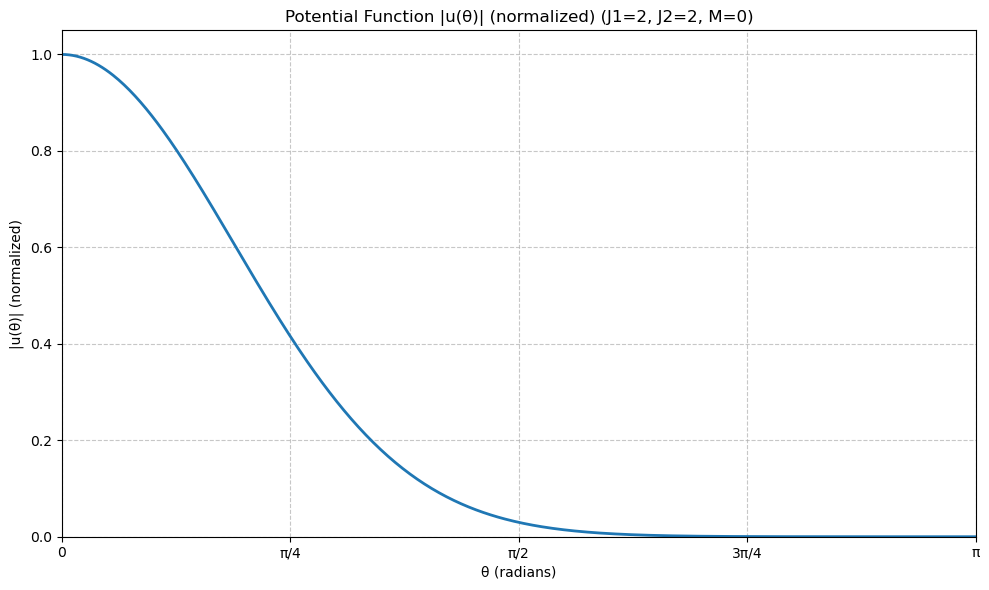

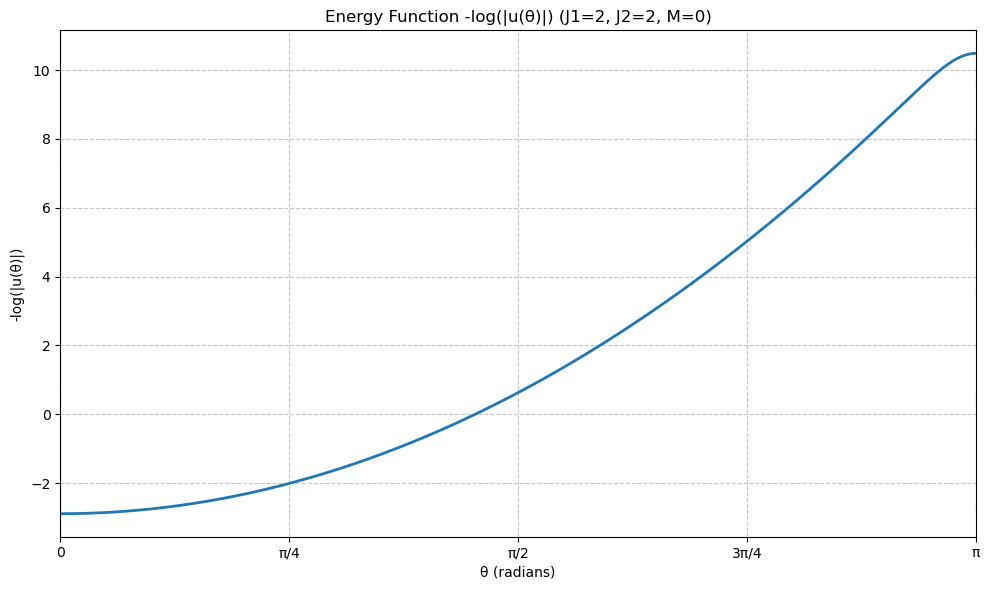

In [95]:
from renormalization_np import track_rg_flow

# Run the RG flow for parameters with M=0 to ensure factorization
J1, J2, M = 2, 2, 0
flow_history = track_rg_flow(J1, J2, M, b=3, d=2, n_max=20, n_steps=10)

# Plot normalized potential
fig_potential2D = plot_2d_potential_energy(
    flow_history[-1],
    mode='potential',
    normalize=True,
    J1=J1, J2=J2, M=M)
plt.show()

# Plot energy
fig_energy2D = plot_2d_potential_energy(
    flow_history[-1],
    mode='energy',
    J1=J1, J2=J2, M=M)
plt.show()

In [97]:
fig_potential2D.savefig(f"potential2D_J{J1}M{M}.png", bbox_inches='tight', dpi=200)
fig_energy2D.savefig(f"energy2D_J{J1}M{M}.png", bbox_inches='tight', dpi=200)

fig_potential2D.savefig(f"potential2D_J{J1}M{M}.eps", bbox_inches='tight', dpi=200)
fig_energy2D.savefig(f"energy2D_J{J1}M{M}.eps", bbox_inches='tight', dpi=200)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


# 3D Potential u(theta, phi), Energy

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_potential_energy(lambda_nm, mode='potential', title=None, n_points=100, 
                            angle_range=(0, np.pi), cmap='viridis', show_colorbar=True,
                            figsize=(10, 8), elev=30, azim=30, normalize=True,
                            epsilon=1e-15, J1=None, J2=None, M=None):
    """
    Plot 3D potential or energy reconstructed from Fourier coefficients.
    
    Args:
        lambda_nm: 2D array of Fourier coefficients
        mode: 'potential' to plot |u(θ,φ)| or 'energy' to plot -log(|u(θ,φ)|) (default: 'potential')
        title: Title for the plot (default: None)
        n_points: Number of points for the angle grid (default: 100)
        angle_range: Tuple with min and max angle values (default: (0, π))
        cmap: Colormap for the surface (default: 'viridis')
        show_colorbar: Whether to show the colorbar (default: True)
        figsize: Figure size (width, height) in inches (default: (10, 8))
        elev: Elevation angle for 3D view (default: 30)
        azim: Azimuth angle for 3D view (default: 30)
        normalize: Whether to normalize the potential so its maximum value is 1 (default: True)
        epsilon: Small value to avoid log(0) when calculating energy (default: 1e-15)
        J1, J2, M: Original model parameters (for reference in title)
        
    Returns:
        fig: Matplotlib figure object
    """
    # Get the maximum Fourier mode from the coefficient matrix size
    n_max = (lambda_nm.shape[0] - 1) // 2
    
    # Create angle grids
    theta = np.linspace(angle_range[0], angle_range[1], n_points)
    phi = np.linspace(angle_range[0], angle_range[1], n_points)
    THETA, PHI = np.meshgrid(theta, phi)
    
    # Initialize potential
    u = np.zeros_like(THETA, dtype=complex)
    
    # Reconstruct potential by summing over all Fourier modes
    for n in range(-n_max, n_max + 1):
        for m in range(-n_max, n_max + 1):
            n_idx = n + n_max
            m_idx = m + n_max
            u += lambda_nm[n_idx, m_idx] * np.exp(1j * (n*THETA + m*PHI))
    
    # Take magnitude of complex potential
    u_mag = np.abs(u)
    
    # Normalize the potential if requested
    if normalize and mode.lower() == 'potential':
        max_val = np.max(u_mag)
        if max_val > 0:
            u_mag = u_mag / max_val
    
    # Calculate the z-value for plotting based on mode
    if mode.lower() == 'energy':
        # Apply small epsilon to avoid log(0)
        z_values = -np.log(u_mag + epsilon)
        z_label = '-log(|u(θ,φ)|)'
        plot_title = 'Energy Function -log(|u(θ,φ)|)'
    else:  # 'potential' mode
        z_values = u_mag
        z_label = '|u(θ,φ)|' + (' (normalized)' if normalize else '')
        plot_title = 'Potential Function |u(θ,φ)|' + (' (normalized)' if normalize else '')
    
    # Create the 3D plot
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the surface
    surf = ax.plot_surface(THETA, PHI, z_values, cmap=cmap, antialiased=True)
    
    # Add colorbar if requested
    if show_colorbar:
        cbar = fig.colorbar(surf, ax=ax, shrink=0.7, aspect=10)
        cbar.set_label(z_label)
    
    # Set labels and title
    ax.set_xlabel('θ (radians)')
    ax.set_ylabel('φ (radians)')
    ax.set_zlabel(z_label)
    
    # Generate a descriptive title if none provided
    if title:
        ax.set_title(title)
    else:
        params_str = ""
        if J1 is not None and J2 is not None:
            params_str = f" (J1={J1}, J2={J2}"
            if M is not None:
                params_str += f", M={M}"
            params_str += ")"
        ax.set_title(f"{plot_title}{params_str}")
    
    # Set z-axis limits for normalized potentials
    if mode.lower() == 'potential' and normalize:
        ax.set_zlim(0, 1.05)
    
    # Set the viewing angle
    ax.view_init(elev=elev, azim=azim)
    
    # Set the tick labels to show π fractions when using range (0, π)
    if angle_range == (0, np.pi):
        tick_positions = np.linspace(0, np.pi, 5)
        tick_labels = ['0', 'π/4', 'π/2', '3π/4', 'π']
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels)
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(tick_labels)
    
    plt.tight_layout()
    
    return fig

100%|██████████| 10/10 [00:19<00:00,  1.91s/it]
/var/folders/56/k5k1hn6s4pd9x__t6s6fpclr0000gn/T/ipykernel_2658/3616660713.py:114: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


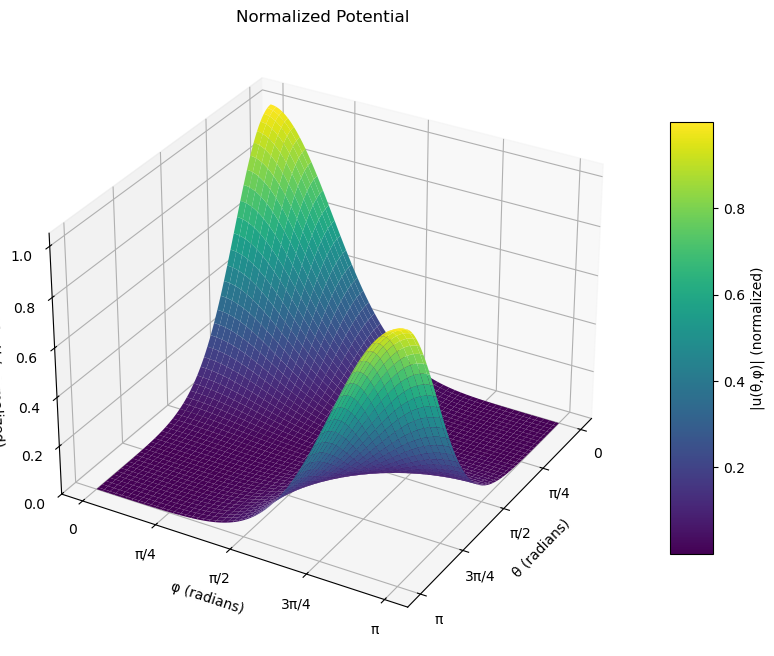

/var/folders/56/k5k1hn6s4pd9x__t6s6fpclr0000gn/T/ipykernel_2658/3616660713.py:114: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


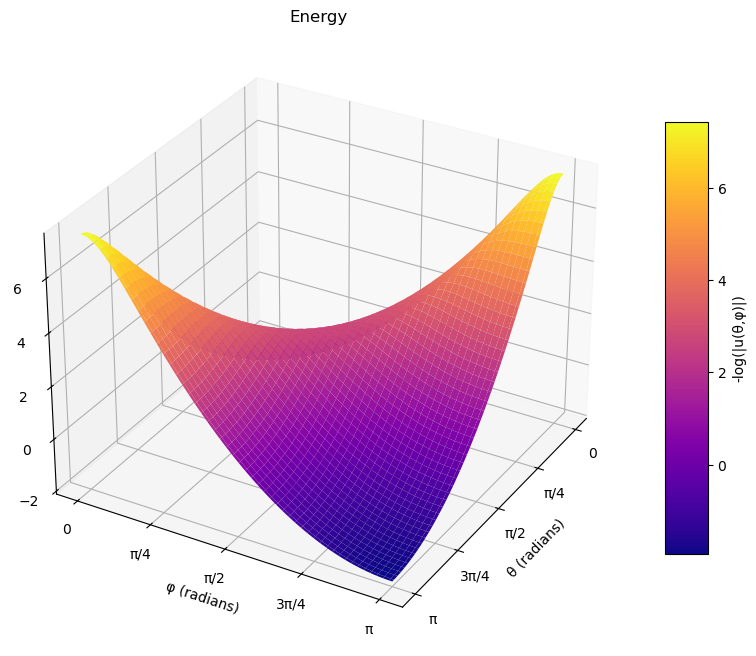

In [99]:
from renormalization_np import track_rg_flow

# Run the RG flow for some parameters
J1, J2, M = 0, 0, 2
flow_history = track_rg_flow(J1, J2, M, b=3, d=2, n_max=20, n_steps=10)

# Plot normalized potential for step 5
fig_potential3D = plot_3d_potential_energy(
    flow_history[-1],
    mode='potential',
    cmap='viridis',
    normalize=True,
    J1=J1, J2=J2, M=M,
    title=f'Normalized Potential'
)
plt.show()

# Plot energy (normalization parameter doesn't affect this mode)
fig_energy3d = plot_3d_potential_energy(
    flow_history[-1],
    mode='energy',
    cmap='plasma',
    J1=J1, J2=J2, M=M,
    title=f'Energy'
)
plt.show()

In [101]:
fig_potential3D.savefig(f"potential3D_J{J1}M{M}.png", bbox_inches='tight', dpi=200)
fig_energy3D.savefig(f"energy3D_J{J1}M{M}.png", bbox_inches='tight', dpi=200)

fig_potential3D.savefig(f"potential3D_J{J1}M{M}.eps", bbox_inches='tight', dpi=200)
fig_energy3D.savefig(f"energy3D_J{J1}M{M}.eps", bbox_inches='tight', dpi=200)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
